**Notebooks used to create figures shown in "Sequana Coverage: Detection and Characterization of Genome Variations using Running Median and Mixture Models" 
Desvillechabrol D., Bouchier C., Kennedy S., Cokelaer T.**

This notebook reproduces all figures in the paper using sequana 0.6.5

# The required data

This notebooks requires as input 3 BED files for the 3 organisms considered. In addition, a genbank and a reference genomes are required (see below).

3 Associated notebooks can be used to reproduce or get the genbank and reference genome files. 

All data are posted (with FastQ files) in https://www.synapse.org/#!Synapse:syn10638358/wiki/465309 (you need a login), so we also provide
the BED, genbank and genome reference files on this github repository https://github.com/sequana/resources/tree/master/coverage and tht 5 required files can be downloaded and uncompressed as follows:

In [1]:
# UNCOMMENT TO DOWNLOAD THE DATA that should be in this directory anyway
#%%bash
#export GITHUB=https://github.com/sequana/resources/raw/master/coverage/
#wget $GITHUB/JB409847.filtered.bed.bz2
#wget $GITHUB/FN433596.filtered.bed.bz2
#wget $GITHUB/S_pombe.filtered.bed.bz2
#wget $GITHUB/FN433596.fasta.bz2
#wget $GITHUB/S_pombe.gbk.bz2
#bunzip2 S_pombe.gbk.bz2
#bunzip2 FN433596.fasta.bz2
#bunzip2 *.filtered.bed.bz2

## Check that the md5sum are correct. You should get:

In [2]:
#md5sum *filtered.bed FN433596.fasta S_pombe.gbk
# 7f100537578c3e19b79d3c6d5b3a01b1  S_pombe.gbk
# 91773301c18597ed1c58e8b0b5f375fa  FN433596.fasta
# 69555501bafce246427faebe3b3f32fc  FN433596.filtered.bed
# 5a2173339eff5475ed64bd242162e0a7  JB409847.filtered.bed
# 12ba8ca543d8a314772ee4246bcdf2f6  S_pombe.filtered.bed

# Install the sequana library
Please, use conda as explained on 
http://sequana.readthedocs.io/en/master/installation.html

In [2]:
from sequana import GenomeCov

In [3]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['legend.edgecolor'] = "black"
matplotlib.rcParams['legend.fontsize'] = "large"

Populating the interactive namespace from numpy and matplotlib


# Figure 1

In [5]:
bacteria = GenomeCov("FN433596.filtered.bed", low_threshold=-4, high_threshold=4)
data = bacteria.chr_list[0]
data.run(20001, circular=True)

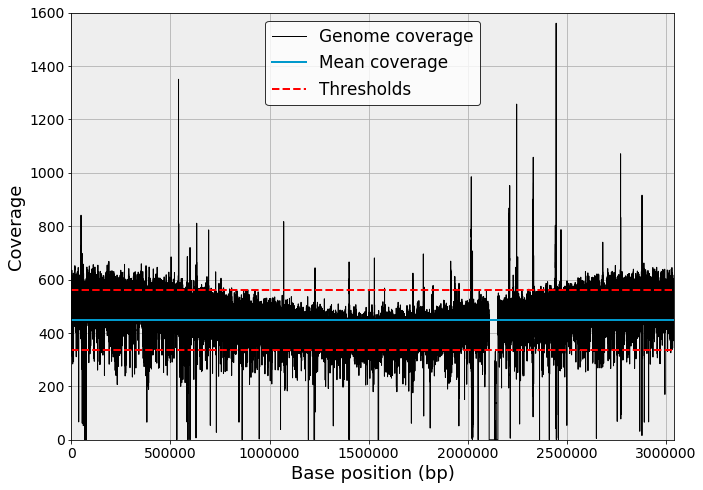

In [6]:
cov_mean = mean(data.df["cov"])
high_t = cov_mean + cov_mean * 25 / 100
low_t = cov_mean - cov_mean * 25 / 100
fig, ax = plt.subplots()
ax.set_facecolor("#eeeeee")
pylab.xlim(0, data.df["pos"].iloc[-1])
p1, = pylab.plot(data.df["cov"], color="k",
                 label="Genome coverage", linewidth=1)
p2 = pylab.axhline(cov_mean, color="#0099cc", linewidth=2, label="Mean coverage")
p3 = pylab.axhline(high_t, color="r", linewidth=2, ls="--", 
                   label="Thresholds")
pylab.axhline(low_t, color="r", linewidth=2, ls="--")
pylab.legend([p1, p2, p3], 
             [p1.get_label(), p2.get_label(), p3.get_label()],
             loc="best")
pylab.xlabel("Base position (bp)", fontsize=18)
pylab.ylabel("Coverage", fontsize=18)
pylab.grid()
pylab.tight_layout()
ylim([0, 1600])
pylab.savefig("mean_coverage.png", dpi=200)

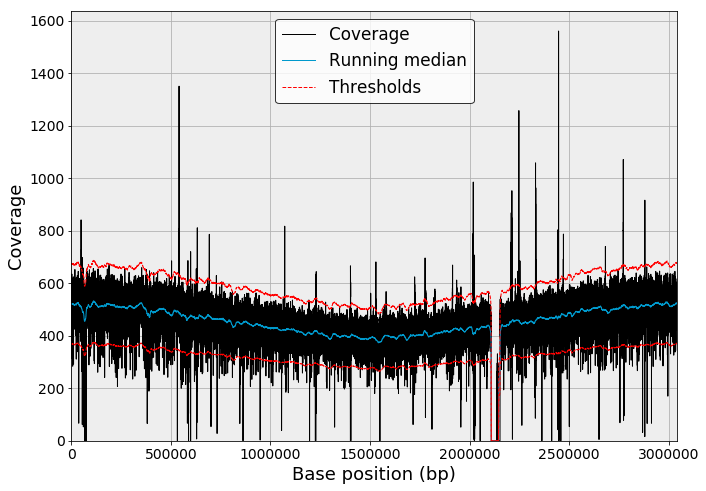

In [7]:
# Bottom panel: Running median
thr = 4
mu = data.best_gaussian["mu"]
sigma = data.best_gaussian["sigma"]
zcov1 = (thr * sigma + mu) * data.df["rm"]
zcov2 = (-thr * sigma + mu) * data.df["rm"]
data.df["high_threshold"] = zcov1
data.df["low_threshold"] = zcov2

data.plot_coverage(set_ylimits=False, sample=False)
pylab.xlabel("Base position (bp)", fontsize=18)
pylab.ylabel("Coverage", fontsize=18)
pylab.grid(True)
#pylab.tight_layout()
pylab.savefig("running_median.png", dpi=200)

# Figure 2 running median versus moving average

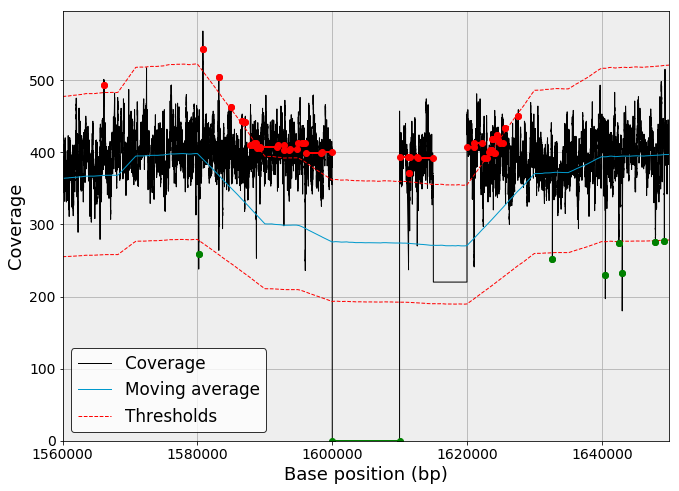

In [8]:
from sequana import GenomeCov
b = GenomeCov("FN433596.filtered.bed")
c = b.chr_list[0]
# We inject a deleted region of 15000 bases
c.df.loc[1600000:1610000, "cov"] *= 0
# and a region of 220 depth of coverage (hald the mean depth of coverage) closeby (5000 bases apart)
c.df.loc[1615000:1620000, "cov"] = 220

# here is a hack where we compute the median just to create the data structure 
c.running_median(40001, circular=True)
# and replace it with the moving average
c.moving_average(40001, circular=True)
c.df['rm'] = c.df['ma']

c.compute_zscore()
c.plot_rois(1560000, 1650000)
legend(["Coverage", "Moving average", "Thresholds"], loc="lower left" )
pylab.xlabel("Base position (bp)", fontsize=18)
pylab.ylabel("Coverage", fontsize=18)
pylab.xticks([1560000,1580000,1600000,1620000,1640000], 
             [1560000,1580000,1600000,1620000,1640000])
pylab.savefig("moving_average_focus.png", dpi=200)

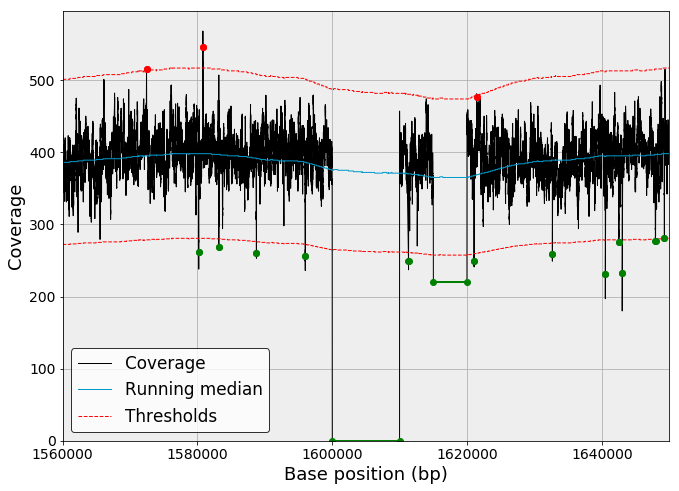

In [9]:
c.running_median(40001, circular=True)
c.compute_zscore()
c.plot_rois(1560000, 1650000)
pylab.xticks([1560000,1580000,1600000,1620000,1640000], 
             [1560000,1580000,1600000,1620000,1640000])
pylab.xlabel("Base position (bp)", fontsize=18)
pylab.ylabel("Coverage", fontsize=18)
pylab.savefig("running_median_focus.png", dpi=200)

# Figure Virus genome 

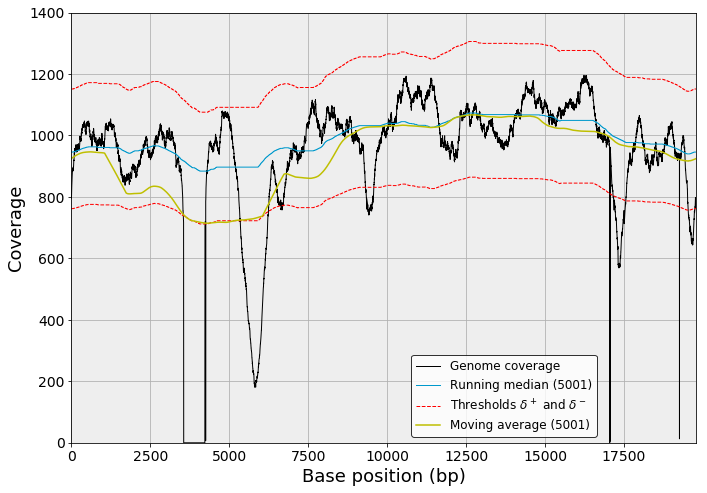

In [10]:
b2 = GenomeCov("JB409847.filtered.bed", low_threshold=-3., high_threshold=3)
chrom = b2.chr_list[0]
chrom.running_median(5001, circular=True)
chrom.compute_zscore()
chrom.moving_average(5001, circular=True)
chrom.plot_coverage()
ylim([0, 1400])
chrom.df['ma'].plot(label=r"MA_{5001}", color="y")
ax = legend([ "Genome coverage", 
             r"Running median (5001)", 
              "Thresholds $\delta^+$ and $\delta^-$", 
             r"Moving average (5001)"], loc="lower right", fontsize=12, 
                ncol=1, bbox_to_anchor=(0.85,0.))
xlabel("Base position (bp)", fontsize=18)
ylabel("Coverage", fontsize=18)
grid(True)
savefig("comp_ma_vs_rm.png", dpi=200)      

# Figure 3

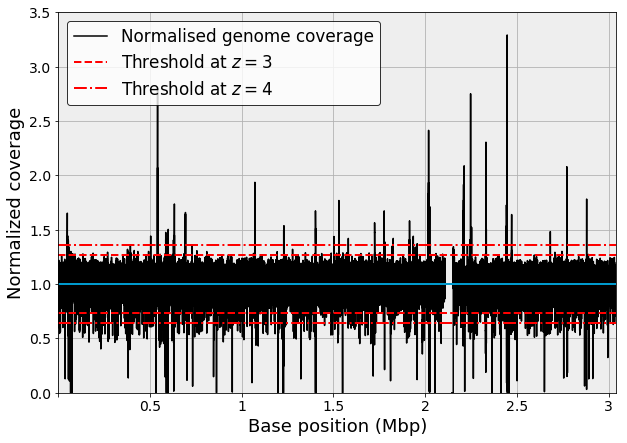

In [11]:
#binwidth = 0.05
#bins = np.arange(min(data.df["scale"]), max(data.df["scale"]) + binwidth,
#        binwidth)

ax_plot = gca()
ax_plot.set_facecolor("#eeeeee")
ax_plot.set_xlim(0,data.df["pos"].iloc[-1])
ax_plot.plot(data.df["scale"], color="k", label='Normalised genome coverage')
ax_plot.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax_plot.set_xticklabels(["", 0.5, 1, 1.5, 2, 2.5, 3])
ax_plot.set_xlabel(r"Base position (Mbp)", fontsize=18)
ax_plot.set_ylabel("Normalized coverage", fontsize=18)
ax_plot.grid()
ax_plot.axhline(1, lw=2,color="#0099cc")
ax_plot.axhline(1.27, lw=2,color="red", ls="--", label="Threshold at $z=3$")
ax_plot.axhline(0.73, lw=2,color="red", ls="--", label="_nolegend")
ax_plot.axhline(1.36, lw=2,color="red", ls="-.", label="Threshold at $z=4$")
ax_plot.axhline(0.64, lw=2,color="red", ls="-.", label="_nolegend")
legend(loc="upper left")
ylim([0, 3.5])
pylab.savefig("normalize_coverage.png", dpi=200)

# Figure 4

In [12]:
# Load the data for the virus, bacteria, fungus
virus = GenomeCov("JB409847.filtered.bed")
ch_virus = virus.chr_list[0]
ch_virus.run(4001, circular=True)

In [13]:
bacteria = GenomeCov("FN433596.filtered.bed")
ch_bacteria = bacteria.chr_list[0]
ch_bacteria.run(20001, circular=True)


In [14]:
fungus = GenomeCov("S_pombe.filtered.bed", chunksize=10000000)
ch_fungus = fungus.chr_list[0]
ch_fungus.run(20001)

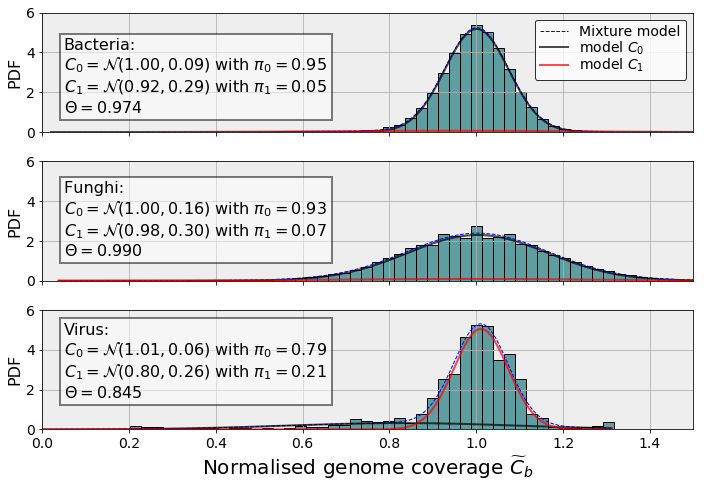

In [16]:
# The plot itself
ax1 = subplot(3,1,1)
ax2 = subplot(3,1,2)
ax3 = subplot(3,1,3)
axes = [ax1, ax2, ax3]
# common xlim for all
space = linspace(0,2,80)
 
ch_bacteria.mixture_fitting.plot(bins=space,ax=ax1,hist_kw={'color':'#5F9EA0', "edgecolor":"k"})
ch_virus.mixture_fitting.plot(bins=space,ax=ax3,hist_kw={'color':'#5F9EA0', "edgecolor":"k"})
ch_fungus.mixture_fitting.plot(bins=space,ax=ax2,hist_kw={'color':'#5F9EA0', "edgecolor":"k"})

for ax in axes: ax.set_xlim([0, 1.5])
for ax in axes: ax.set_ylim([0, 6])
for ax in axes: ax.grid(True)
for ax in axes: ax.set_facecolor("#eeeeee")

# share the xticks
ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax3.set_xlabel(r"Normalised genome coverage $\widetilde{C}_b$", fontsize=20)

for ax in axes: ax.set_ylabel("PDF", fontsize=16)

text(0.05,15.9, "Bacteria:\n$C_0=\mathcal{N}(1.00, 0.09)$ with $\pi_0=0.95$" +
    "\n$C_1=\mathcal{N}(0.92, 0.29)$ with $\pi_1=0.05$ \n$\Theta=0.974$",
    bbox={"lw":2,"facecolor":"white", "alpha":0.5}, fontsize=16)

text(0.05,8.7, "Funghi: \n$C_0=\mathcal{N}(1.00, 0.16)$ with $\pi_0=0.93$ "+
    "\n$C_1=\mathcal{N}(0.98, 0.30)$ with $\pi_1=0.07$ \n$\Theta=0.990$",
    bbox={"lw":2, "facecolor":"white", "alpha":0.5},fontsize=16)

text(0.05,1.6,"Virus:\n$C_0=\mathcal{N}(1.01, 0.06)$ with $\pi_0=0.79$ \n" +
    "$C_1=\mathcal{N}(0.80, 0.26)$ with $\pi_1=0.21$\n$\Theta=0.845$", 
    bbox={"lw":2, "facecolor":"white","alpha":0.5}, fontsize=16)


for ax in axes:
    ax.get_lines()[2].set_color("red")
    ax.get_lines()[2].set_linestyle("-")
    ax.get_lines()[2].set_linewidth(2)
    ax.get_lines()[1].set_color("black")
    ax.get_lines()[1].set_linewidth(2)
    ax.get_lines()[1].set_linestyle("-")
    ax.get_lines()[0].set_linewidth(1)
    ax.get_lines()[0].set_linestyle("--")
    ax.get_lines()[0].set_color("blue")
ax1.legend(['Mixture model','model $C_0$', 'model $C_1$'], 
           loc="upper right", labelspacing=0, fontsize=14)

pylab.tight_layout()

# Figure 5

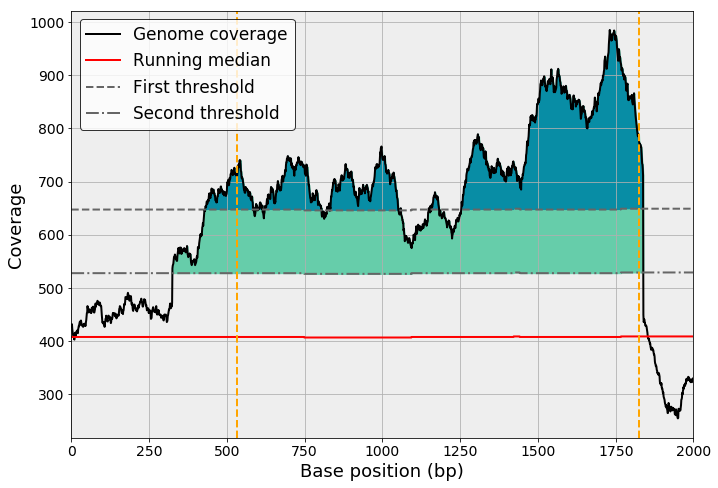

In [17]:
# Double threshold picture. Reusing the bacteria data
region = ch_bacteria.df[2017000:2019000].copy()
region['pos'] -= 2017000
region.index = range(2000)
thr = 8
mu = data.best_gaussian["mu"]
sigma = data.best_gaussian["sigma"]
zcov1 = (thr * sigma + mu) * region["rm"]
zcov2 = ((thr/2) * sigma + mu) * region["rm"]
region["threshold1"] = zcov1
region["threshold2"] = zcov2


fig, ax = plt.subplots()
ax.set_facecolor("#eeeeee")
p0, = pylab.plot(region["cov"], color="k", label="Genome coverage", 
                 linewidth=2)
p1, = pylab.plot(region["rm"], "r", linewidth=2, label="Running median")
p2, = pylab.plot(region["threshold1"], linewidth=2, color="#666666", ls="--",
                 label="First threshold")
p3, = pylab.plot(region["threshold2"], linewidth=2, color="#666666", ls="-.",
                 label="Second threshold")
ax.fill_between(region["pos"], region["cov"], region["threshold2"], 
        where=region["cov"] > region["threshold2"], color="#66cdaa")
ax.fill_between(region["pos"], region["cov"], region["threshold1"], 
        where=region["cov"] > region["threshold1"], color="#088da5")
pylab.legend([p0, p1, p2, p3], 
             [p0.get_label(), p1.get_label(), p2.get_label(), 
              p3.get_label()], loc="upper left")
pylab.xlabel("Base position (bp)", fontsize=18)
pylab.ylabel("Coverage", fontsize=18)
pylab.grid()
pylab.tight_layout()
pylab.axvline(531, lw=2, color="orange", ls="--")
pylab.axvline(1824, lw=2, color="orange", ls="--")
xlim([0,2000])
pylab.savefig("double_threshold.png", dpi=200)

# Figure 6

Computing 2D histogram. Please wait


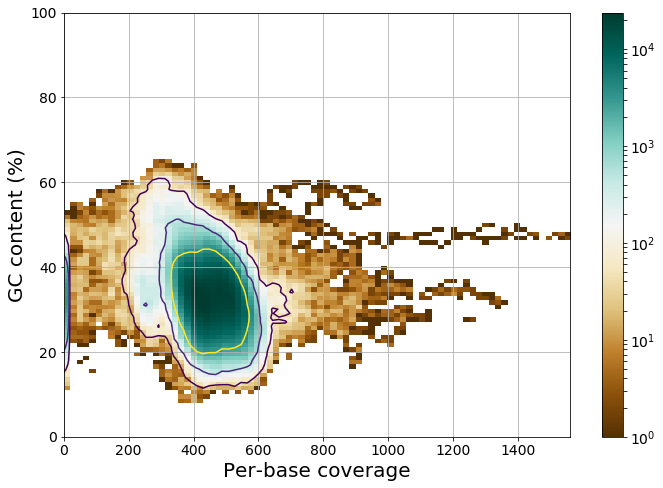

In [18]:
b = GenomeCov("FN433596.filtered.bed")
c = b.chr_list[0]
b.compute_gc_content("FN433596.fasta")
c.plot_gc_vs_coverage(Nlevels=6, bins=[80,57], cmap="BrBG")
savefig("hist2d.png", dpi=200)
savefig("hist2d.eps", dpi=200)

# Figure 7

This figure and others are available in the notbook 09 as well as explanations.

In [42]:
# load CNV from cnvnator
from sequana.cnv import CNVnator
cnvnator = CNVnator("cnvnator_events_fig7_bin6.txt").df
cnvnator = CNVnator("cnvnator_events_fig7_bin100.txt").df

# load the BED and ROIs pre-generated using W=100000
b = GenomeCov("FN433596.bed")
chrom = b.chr_list[0]
chrom.run(100001, circular=True, cnv_delta=10)
#chromosome.rois.df.to_csv("rois_100000_10.csv")    

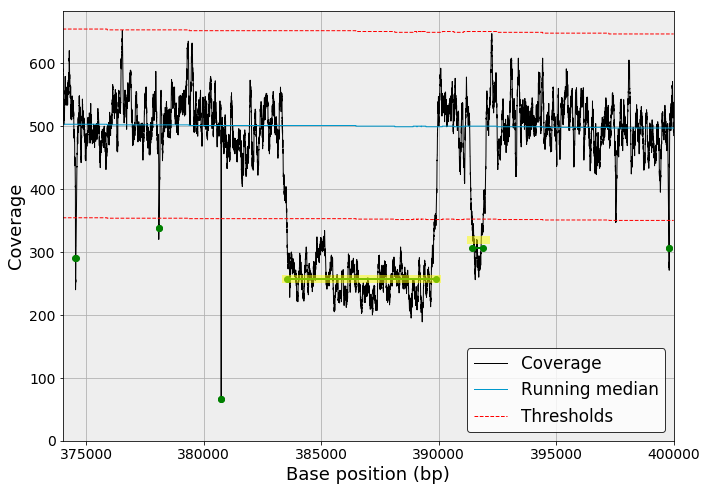

In [41]:
   
def plot_variant(chrom, x1=526000, x2=538000):
    clf()    
    chrom.plot_rois(x1, x2)
    roi = chrom.rois
    low = roi.get_low_rois()
    high = roi.get_high_rois()
    chr = chrom
    highT = (chr.thresholds.high * chr.best_gaussian["sigma"] +
         chr.best_gaussian["mu"]) * chr.df["rm"]
    lowT = (chr.thresholds.low * chr.best_gaussian["sigma"] +
        chr.best_gaussian["mu"]) * chr.df["rm"]

    for k,v in low.iterrows():        
        Y1 = chr.df['cov'].loc[v.start:v.end]
        Y2 = lowT.loc[v.start:v.end] 
        Y1 = Y1.combine(Y2, max) *0
        #if v.start > x1 and v.end<x2:
        #    try:fill_between(range(v.start, v.end+1), Y1, Y2, 
        #                     alpha=0.3, color="green")
        #    except:pass   
    # CNVntator 
    xlim([x1, x2])
    x1, x2 = xlim()
    L = x2-x1
    for i in range(len(cnvnator)):
        this = cnvnator.loc[i]
        axhline(chrom.df['cov'].mean() * this[3], (this.start-x1)/L, 
                (this.end-x1)/L, lw=8, color="yellow", alpha=0.5)
    xlabel("Base position (bp)")
    
plot_variant(chrom, 374000,400000)
pylab.xlabel("Base position (bp)", fontsize=18)
pylab.ylabel("Coverage", fontsize=18)
pylab.savefig("comp_cnv_bin100_2.png", dpi=200)

# Figure 8

See notebook 08 on github.com/sequana_resources/coverage

Or run population.py script. You will still need the 6 BED files created in notebook 8 !

# Figure 9

In [43]:
b6 = GenomeCov("ERR316404.bed")
c6 = b6.chr_list[0]
c6.run(40000)

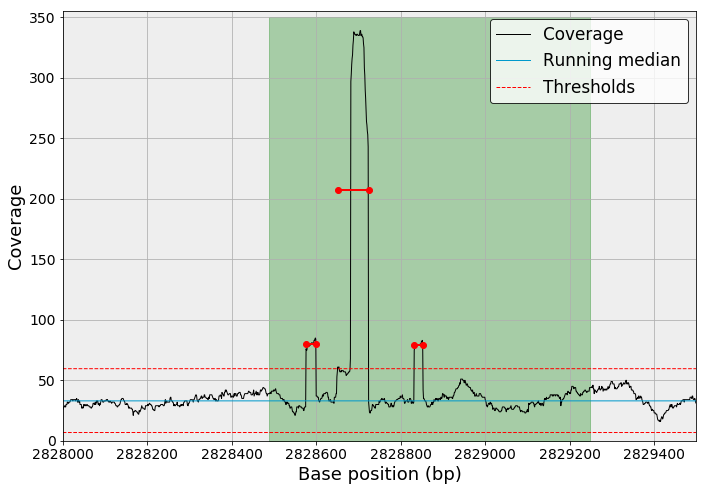

In [51]:
#_, axes = subplots(2,1)
#sca(axes[0])
c6.plot_rois(2828000,2829500, clf=False)
axes[0].fill_between([2828489,2829247],0,350, alpha=0.3, color="green")
pylab.xlabel("Base position (bp)", fontsize=18)
pylab.ylabel("Coverage", fontsize=18)
#sca(axes[1])
#c3.plot_rois(2828000,2829500, clf=False)
#axes[1].
fill_between([2828489,2829247],0,350, alpha=0.3, color="green")
savefig("triple_event.png", dpi=200)

# Figure (not included)

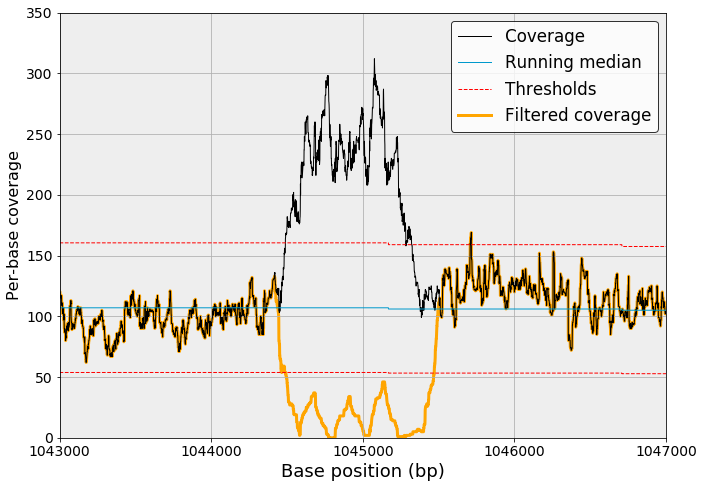

In [6]:
b = GenomeCov("S_pombe.filtered.bed", "S_pombe.gbk")
c = b.chr_list[1]
c.running_median(20001, circular=False)
c.compute_zscore()
c.df = c.df.iloc[1000000:1100000]
c.plot_coverage()
c.df.mapq0.plot(color="orange", zorder=-1, label="Filtered coverage", lw=3)
xlim([1043000,1047000])
grid()
ylim([0,350])
legend()
l = gca().get_legend()
l.set_title("")
xticks([1043000,1044000,1045000,1046000,1047000], 
       [1043000,1044000,1045000,1046000,1047000])
xlabel("Base position (bp)", fontsize=18)
tight_layout()
savefig("excess.png", dpi=200)
savefig("excess.eps", dpi=200)

# Figure (not included)

In [7]:
b = GenomeCov("S_pombe.filtered.bed", "S_pombe.gbk")
c = b.chr_list[0]
c.running_median(20001, circular=False)
c.compute_zscore()
# To speed up the plotting, let us keep only 200,000 data points
c.df = c.df.iloc[3900000:4100000]

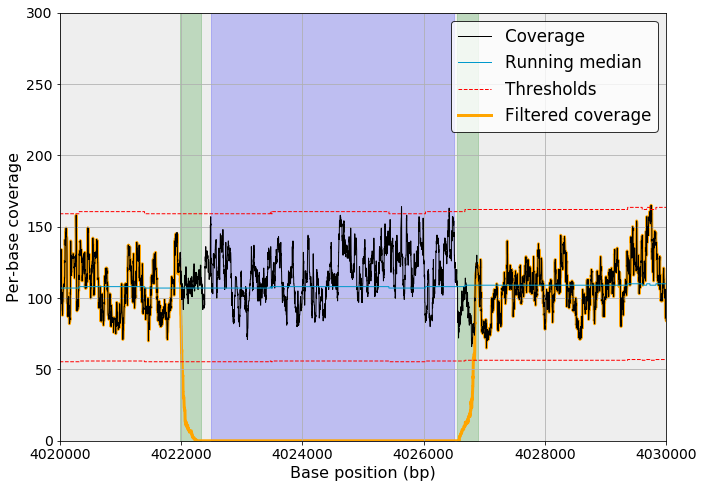

In [10]:
from sequana.tools import genbank_features_parser
c.plot_coverage()
c.df.mapq0.plot(color="orange", zorder=-1, label="Filtered coverage", lw=3)
XMIN, XMAX = 4020000,4030000
xlim([XMIN, XMAX])
grid()
YMAX = 300
ylim([0,YMAX])
legend()
l = gca().get_legend()
l.set_title("")
tight_layout()
xlabel("Base position (bp)", fontsize=16)

# highlight repeat regions
gbk = genbank_features_parser("S_pombe.gbk")
repeats = [this for this in gbk["CU329670"] if this['type'] == "repeat_region"\
           and this['gene_start']> XMIN and this['gene_end']<XMAX]
for repeat in repeats:
    fill_between([repeat["gene_start"], repeat["gene_end"]], [YMAX,YMAX],
        color="green", alpha=0.2, zorder=-2)

# highlight CDS retrotransposable
CDSs = [this for this in gbk["CU329670"] if this['type'] == "CDS" and \
        this['gene_start']> XMIN and this['gene_end']<XMAX]
for cds in CDSs:
    if cds['product'] == "retrotransposable element":
        fill_between([cds["gene_start"], cds["gene_end"]], [YMAX, YMAX],
            alpha=0.2, color="blue", zorder=-2)

savefig("repeats.png", dpi=200)
savefig("repeats.eps", dpi=200)

# Figure running median performances

In [12]:
import pandas as pd

In [32]:
### INSTALL blist using pip install blist==1.3.6
import scipy.signal
from sequana.running_median import RunningMedian
from easydev import Timer
import pandas as pd
data = pylab.randn(1000000)
windows = [101,501,1001,5001,10001, 20001, 30001, 40001, 50001, 100001, 
           200001, 400001]
times2 = []
times3 = []
times_pandas = [] 
times_scipy = []

def compute_times(do_scipy=True):
    for window in windows:
        print(window)
        with Timer(times2):
            results = RunningMedian(data, window).run()
        with Timer(times3):
            from blist import blist
            results = RunningMedian(data, window, blist).run()
        with Timer(times_pandas):
            # The DataFrame creation is taken into account here but in the
            # Genomecov, the data is already formatted as a DataFrame, do we
            # want to substract this time ?
            results = pd.DataFrame(data).rolling(window, center=True).median()
        if do_scipy:
            with Timer(times_scipy):
                results = scipy.signal.medfilt(data, window)
            print(times_scipy[-1])
    print(times_scipy)

# Uncomment this to re-run the function, that takes long time especially 
# with scipy set to True
compute_times(do_scipy=False)

101
501
1001
5001
10001
20001
30001
40001
50001
100001
200001
400001
800001
[]


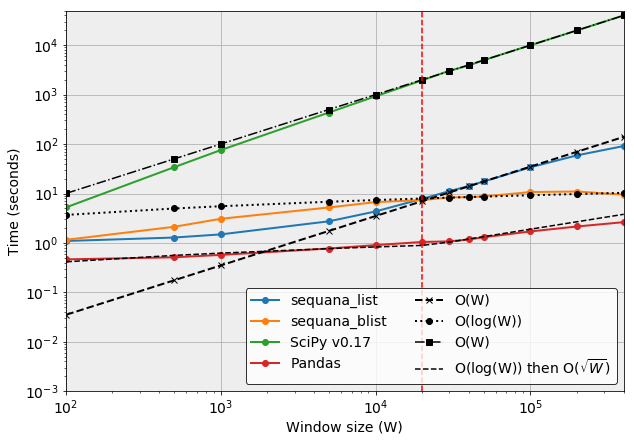

In [35]:
windows = [101,501,1001,5001,10001, 20001, 30001, 40001, 50001, 100001, 200001, 400001]
times2 = [1.095, 1.285, 1.488, 2.739, 4.335, 7.811, 11.176,
          14.191, 17.533, 33.9416, 59.198, 91.28] 
times3 = [1.1578, 2.121, 3.077, 5.218, 6.695, 7.340, 8.330, 
          8.463, 8.719, 10.699, 10.969, 9.48]
times_scipy = [5.27, 34.05, 75.5, 435.36, 925.13, 1950.7, 
               3046.56, 3901, 4996, 9993, 19986, 40151]
times_pandas =  [0.465, 0.512, 0.572, 0.771, 0.903, 1.046, 1.075,
                 1.175, 1.303, 1.708, 2.151, 2.631]
#times_scipy = times_scipy[0:11]

def plotting():
    f = pylab.figure()
    pylab.semilogy(windows, times2, label="sequana_list", marker="o", lw=2)
    pylab.semilogy(windows, times3, label="sequana_blist", marker="o", lw=2)
    pylab.semilogy(windows, times_scipy, label="SciPy v0.17", marker="o", lw=2)
    pylab.semilogy(windows, times_pandas, label="Pandas", marker="o", lw=2)
    ax = f.get_axes()[0]
    ax.set_facecolor("#eeeeee")

    pylab.xlabel("Window size (W)")
    pylab.ylabel("Time (seconds)")

    pylab.ylim([0.001, 50000])
    pylab.xlim([100, 400010])

    pylab.grid()

    x = np.array(windows)
    pylab.semilogy(x, 3.5e-4*x, "kx--", lw=2, label="O(W)")
    pylab.semilogy(x, 0.8*(pylab.log(x)), "ko:", lw=2, label='O(log(W))') # blist
    pylab.semilogy(x, 0.1*x, "ks-.", label="O(W)") # scipy

    pylab.semilogy(x, list(9e-2*pylab.log(x[0:6])) + list(6e-3*x[6:]**0.5),
        "k--", label=r"O(log(W)) then O($\sqrt{W}$)")

    pylab.axvline(20000, color="r",  linestyle="--")
    pylab.legend(loc="lower right", fontsize="medium", ncol=2)
    pylab.savefig("running_mean_comp.png")
    pylab.loglog()
    pylab.savefig("running_mean_comp_loglog.png")

plotting()

# Table1

## virus column

In [4]:
# Load the data for the virus, bacteria, funghi
virus = GenomeCov("JB409847.filtered.bed")
ch_virus = virus.chr_list[0]
ch_virus.running_median(5001, circular=True)
ch_virus.compute_zscore()

In [15]:
# standard metrics
def plot_stats(data):
    stats = data.get_stats()
    stats["mu"] = ["", 1]
    # centralness and mixture model related
    for k,v in data.best_gaussian.items():
        stats[k] = [v]
    stats["centraless"] = [data.get_centralness()]
    stats = pd.DataFrame(stats).T
    return stats
plot_stats(ch_virus)

,0
BOC,96.595100
CV,0.254645
DOC,931.310735
MAD,71.000000
Median,988.000000
STD,237.153920
centraless,0.868452
mu,1.011224
pi,0.851098
sigma,0.068569


## bacteria

In [18]:
bacteria = GenomeCov("FN433596.filtered.bed")
ch_bacteria = bacteria.chr_list[0]
ch_bacteria.running_median(5001, circular=True)
ch_bacteria.compute_zscore()

WARNING [sequana]:  
Found mixture model parameters (k=2) where  |mu0-mu1| < sigma0. k=1 could be a better choice.mu0=0.9994826833416014, m1=0.9729187164266592, sigma0=0.07223993143698498, sigma1=0.30810318358668204


In [19]:
plot_stats(ch_bacteria)

,0
BOC,98.463859
CV,0.187838
DOC,447.805918
MAD,44.000000
Median,453.000000
STD,84.115099
centraless,0.960712
mu,0.999483
pi,0.962268
sigma,0.072240


In [ ]:
# fungus case

In [21]:
fungus = GenomeCov("S_pombe.filtered.bed")
ch_fungus = fungus.chr_list[0]
ch_fungus.running_median(20001)
ch_fungus.compute_zscore()
plot_stats(ch_fungus)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WARNING [sequana]:  
Found mixture model parameters (k=2) where  |mu0-mu1| < sigma0. k=1 could be a better choice.mu0=1.0016846179530743, m1=0.993576451176356, sigma0=0.1623235560435524, sigma1=0.3097322232293308


,0
BOC,99.997660
CV,0.189097
DOC,105.326499
MAD,12.000000
Median,105.000000
STD,19.916975
centraless,0.986589
mu,1.001685
pi,0.932079
sigma,0.162324


In [23]:
fungus = GenomeCov("S_pombe.filtered.bed")
ch_fungus = fungus.chr_list[0]
ch_fungus.running_median(5001)
ch_fungus.compute_zscore()
plot_stats(ch_fungus)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WARNING [sequana]:  
Found mixture model parameters (k=2) where  |mu0-mu1| < sigma0. k=1 could be a better choice.mu0=1.0027822620022897, m1=0.9843636781690419, sigma0=0.1568422428323304, sigma1=0.28133013193623313


,0
BOC,99.997660
CV,0.189097
DOC,105.326499
MAD,12.000000
Median,105.000000
STD,19.916975
centraless,0.985587
mu,1.002782
pi,0.909135
sigma,0.156842
